In [488]:
!jupyter nbconvert --to script train_example.ipynb

[NbConvertApp] Converting notebook train_example.ipynb to script
[NbConvertApp] Writing 12938 bytes to train_example.py


In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from config import args
from pytorch_lightning import Trainer, loggers
from models import SegmentationModel
from augmentations import get_transforms
from datasets import get_train_val_dataloaders
import warnings 
warnings.filterwarnings(action= 'ignore')

# Get augmentation

In [3]:
transform_train=get_transforms('rcf')
transform_train_512=get_transforms('rcf512')
transform_val=get_transforms('center_c')
transform_val_512=get_transforms('center_c512')


# transform_train_sm=get_transforms('rcr128')
# transform_val_sm=get_transforms('center_cr128')

# Get data loaders

In [486]:
train_dataloader, val_dataloader = get_train_val_dataloaders(
    transform_train=transform_train, transform_val=transform_val,
    include_massachusetts=False,
    num_workers=8,
    batch_size=4,
)

train_dataloader_512, val_dataloader_512 = get_train_val_dataloaders(
    transform_train=transform_train_512, transform_val=transform_val_512,
    include_massachusetts=False,
    num_workers=8,
    batch_size=4,
    large=True
)

train_dataloader_full, _ = get_train_val_dataloaders(
    split_percent=1.00,
    transform_train=transform_train, transform_val=None,
    include_massachusetts=False,
    num_workers=8,
    batch_size=4,
)

train_dataloader_full_512, _ = get_train_val_dataloaders(
    split_percent=1.00,
    transform_train=transform_train_512, transform_val=None,
    include_massachusetts=False,
    num_workers=8,
    batch_size=4,
    large=True
)

# Get model

In [271]:
# model_256 = SegmentationModel.load_from_checkpoint('./logs/lightning_logs/version_175/checkpoints/epoch=179-step=1260.ckpt',seg_model='deeplabv3plus')

In [162]:
# model_512 = SegmentationModel.load_from_checkpoint('./logs/lightning_logs/version_174/checkpoints/epoch=176-step=1239.ckpt', seg_model='deeplabv3plus')

In [377]:
# model_256_unet = SegmentationModel.load_from_checkpoint('./logs/lightning_logs/version_176/checkpoints/epoch=179-step=1260.ckpt',seg_model='unet')

In [479]:
# model_512_unet = SegmentationModel.load_from_checkpoint('./logs/lightning_logs/version_177/checkpoints/epoch=187-step=1316.ckpt', seg_model='unet')

In [4]:
model_256_unet_full = SegmentationModel.load_from_checkpoint('./logs/unet_256_full/version_0/checkpoints/epoch=179-step=1620.ckpt', seg_model='unet')

In [29]:
model_512_unet_full = SegmentationModel.load_from_checkpoint('./logs/unet_512_full/version_0/checkpoints/epoch=179-step=1620.ckpt', seg_model='unet')

# Train model

In [ ]:
def get_trainer(name):
    tb_logger = loggers.TensorBoardLogger(save_dir="logs/", name=name)
    trainer = Trainer(gpus=[0,1,2,3],
                  max_epochs=180, 
                  logger=tb_logger,
                  accelerator='ddp',
                  resume_from_checkpoint=args.checkpoint_path,
                  log_every_n_steps=10
    )
    return trainer

In [ ]:
unet_256 = SegmentationModel('unet')    
unet_512 = SegmentationModel('unet')    
dlv3_256 = SegmentationModel('deeplabv3plus')    
dlv3_512 = SegmentationModel('deeplabv3plus')    


trainer = get_trainer('unet_256_full')
trainer.fit(unet_256, train_dataloader_full)
trainer = get_trainer('unet_512_full')
trainer.fit(unet_512, train_dataloader_full_512)
trainer = get_trainer('dlv3_256_full')
trainer.fit(dlv3_256, train_dataloader_full)
trainer = get_trainer('dlv3_512_full')
trainer.fit(dlv3_512, train_dataloader_full_512)

In [30]:
# # model=model.train()
# args.gpus = [0,1,2,3] # Remove this line if you actually have gpus
# # args.gpus = [0] # Remove this line if you actually have gpus


# trainer.fit(model_256, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 29.1 M
-------------------------------
29.1 M    Trainable params
0         Non-trainable params
29.1 M    Total params
116.232   Total estimated model params size (MB)


A Jupyter Widget

A Jupyter Widget

Traceback (most recent call last):
  File "/root/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/root/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/root/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


A Jupyter Widget

Exception ignored in: <function _releaseLock at 0x7f4a26429700>
Traceback (most recent call last):
  File "/root/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


# Visualize

In [309]:
import cv2
import numpy as np

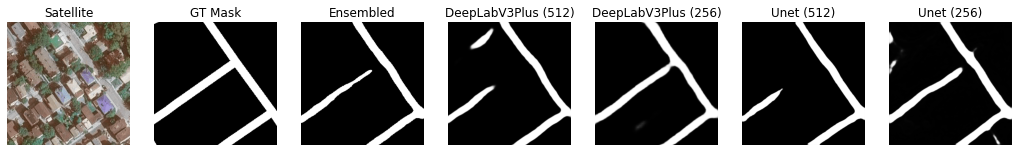

In [483]:
import matplotlib.pyplot as plt
import torch
idx=11
img_256, mask_256 = val_dataloader.dataset[idx]
img_512, mask_512 = val_dataloader_512.dataset[idx]
# fused = model.model.get_fused_input(torch.Tensor(img[None,:]))
pred_mask_512=model_512.predict(torch.Tensor(img_512[None,:]).to(model_512.device)).detach().cpu().numpy()
pred_mask_256=model_256.predict(torch.Tensor(img_256[None,:]).to(model_256.device)).detach().cpu().numpy()
pred_mask_unet_256=model_256_unet.predict(torch.Tensor(img_256[None,:]).to(model_256.device)).detach().cpu().numpy()
pred_mask_unet_512=model_512_unet.predict(torch.Tensor(img_512[None,:]).to(model_512_unet.device)).detach().cpu().numpy()

resized_pred_mask = cv2.resize(pred_mask_512.transpose(1,2,0), (256,256), interpolation=cv2.INTER_CUBIC)
resized_pred_mask_unet = cv2.resize(pred_mask_unet_512.transpose(1,2,0), (256,256), interpolation=cv2.INTER_CUBIC)
ensembled = np.rint(((pred_mask_256 + resized_pred_mask + pred_mask_unet_256 + resized_pred_mask_unet)/4))
f, axarr = plt.subplots(1,7)
f.set_figheight(18)
f.set_figwidth(18)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[4].axis('off')
axarr[5].axis('off')
axarr[6].axis('off')
axarr[0].title.set_text('Satellite')
axarr[1].title.set_text('GT Mask')
axarr[2].title.set_text('Ensembled')
axarr[3].title.set_text('DeepLabV3Plus (512)')
axarr[4].title.set_text('DeepLabV3Plus (256)')
axarr[5].title.set_text('Unet (512)')
axarr[6].title.set_text('Unet (256)')
_ = axarr[0].imshow(img_256.transpose(1,2,0))
_ = axarr[1].imshow(mask_256.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)
_ = axarr[2].imshow(ensembled.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)
_ = axarr[3].imshow(pred_mask_512.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)
_ = axarr[4].imshow(pred_mask_256.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)
_ = axarr[5].imshow(pred_mask_unet_512.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)
_ = axarr[6].imshow(pred_mask_unet_256.transpose(1,2,0), cmap='gray', vmin=0, vmax=1)


In [7]:
# pred_mask = pred[:,:2,:,:].argmax(dim=1).numpy()
# pred_canny = pred[:,2:4,:,:].argmax(dim=1).numpy()

In [8]:
# pred[:,2:4,:,:].shape

In [9]:
# plt.imshow(pred_mask.transpose(1,2,0))

In [10]:
# plt.imshow(pred_canny.transpose(1,2,0))

In [12]:
# mask=(torch.Tensor(mask[None,:]).to(model.device))

In [11]:
# # model.discriminator(softmaxed[None,:].to(model.device))
# model.discriminator(mask.to(model.device))

In [ ]:
# import matplotlib.pyplot as plt
# import torch

# img, mask, canny = val_dataloader.dataset[4]
# # fused = model.model.get_fused_input(torch.Tensor(img[None,:]))
# pred_mask=model.predict(torch.Tensor(img[None,:]).to(model.device), torch.Tensor(canny[None,:]).to(model.device)).detach().cpu().numpy()
# f, axarr = plt.subplots(1,4)
# _ = axarr[0].imshow(img.transpose(1,2,0))
# _ = axarr[1].imshow(mask.transpose(1,2,0))
# _ = axarr[2].imshow(pred_mask.transpose(1,2,0))
# _ = axarr[3].imshow(canny.transpose(1,2,0))
# # _ = axarr[3].imshow(fused[0,3:,...].numpy().transpose(1,2,0))

In [ ]:
# torch.Tensor(canny).shape

In [ ]:
# # model.model.edgemap_encoder(edgemap)
# edgemap = model.hed_model(x)
# edgemap_features = model.model.edgemap_encoder(edgemap)
        

In [5]:
import cv2
import numpy as np
from pathlib import Path

In [30]:
test_images_800_dir = Path('./data/test/images_800/')

In [7]:
test_paths = list(test_images_dir.glob('*.png'))

In [31]:
test_800_paths = list(test_images_800_dir.glob('*.png'))

In [19]:
img=cv2.imread(str(test_paths[0]))[None,:].transpose(0,3,1,2) / 255

In [32]:
img_800=cv2.imread(str(test_800_paths[0]))[None,:].transpose(0,3,1,2) / 255

In [34]:
pred_mask = model_256_unet_full.predict_full_mask(img)
pred_mask_800 = model_512_unet_full.predict_full_mask(img_800)

In [35]:
pred_mask = pred_mask.numpy()
pred_mask_800 = pred_mask_800.numpy()

In [36]:
pred_mask_800

array([[[[6.24306142e-01, 6.95586681e-01, 8.57277870e-01, ...,
          4.47836472e-03, 1.10722855e-02, 2.92905159e-02],
         [7.04096675e-01, 9.34427619e-01, 9.62440014e-01, ...,
          1.01345091e-03, 9.64540697e-04, 6.96959114e-03],
         [8.45739007e-01, 9.63384926e-01, 9.82410669e-01, ...,
          4.90399252e-04, 7.00685370e-04, 3.61831440e-03],
         ...,
         [4.81199240e-03, 5.07988734e-04, 5.53922611e-04, ...,
          5.92297467e-04, 1.06482371e-03, 5.04023442e-03],
         [2.72181444e-02, 1.70620892e-03, 9.97306313e-04, ...,
          8.88635637e-04, 1.00377388e-03, 2.28080573e-03],
         [5.51650152e-02, 8.42961296e-03, 8.12105089e-03, ...,
          1.13937566e-02, 1.85531005e-02, 4.00132574e-02]]]],
      dtype=float32)

In [37]:
import matplotlib.pyplot as plt

In [38]:
pred_mask = pred_mask[0].transpose(1,2,0)
pred_mask_800 = pred_mask_800[0].transpose(1,2,0)


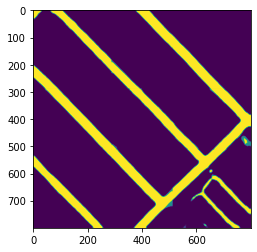

In [41]:
plt.imshow(pred_mask_800)

In [50]:
idx = 0
predictions_dir = Path('./data/test/predictions_unet_256/')
test_images_dir = Path('./data/test/images/')
predictions_dir.mkdir(exist_ok=True)

for img_path in test_paths:
    print(f'{idx}/{len(test_paths)}')
    idx += 1
    img = cv2.imread(str(img_path))
    img = (img.transpose(2,0,1) / 255).astype(np.float32)[None,:]
    pred_mask = model_256_unet_full.predict_full_mask(img).cpu().numpy()[0]
    cv2.imwrite(str(predictions_dir / img_path.stem) + '.png',255*pred_mask.transpose(1,2,0))

0/144
1/144
2/144
3/144
4/144
5/144
6/144
7/144
8/144
9/144
10/144
11/144
12/144
13/144
14/144
15/144
16/144
17/144
18/144
19/144
20/144
21/144
22/144
23/144
24/144
25/144
26/144
27/144
28/144
29/144
30/144
31/144
32/144
33/144
34/144
35/144
36/144
37/144
38/144
39/144
40/144
41/144
42/144
43/144
44/144
45/144
46/144
47/144
48/144
49/144
50/144
51/144
52/144
53/144
54/144
55/144
56/144
57/144
58/144
59/144
60/144
61/144
62/144
63/144
64/144
65/144
66/144
67/144
68/144
69/144
70/144
71/144
72/144
73/144
74/144
75/144
76/144
77/144
78/144
79/144
80/144
81/144
82/144
83/144
84/144
85/144
86/144
87/144
88/144
89/144
90/144
91/144
92/144
93/144
94/144
95/144
96/144
97/144
98/144
99/144
100/144
101/144
102/144
103/144
104/144
105/144
106/144
107/144
108/144
109/144
110/144
111/144
112/144
113/144
114/144
115/144
116/144
117/144
118/144
119/144
120/144
121/144
122/144
123/144
124/144
125/144
126/144
127/144
128/144
129/144
130/144
131/144
132/144
133/144
134/144
135/144
136/144
137/144
138/14

In [51]:
pred_mask.shape

(1, 400, 400)

In [166]:
# import torch
# import torch.nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader

# import pytorch_lightning as pl

# from torch_enhance.datasets import BSDS300, Set14, Set5
# from torch_enhance.models import SRCNN, SRResNet, VDSR, EDSR
# from torch_enhance import metrics


# class Module(pl.LightningModule):

#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=1e-3)

#     def training_step(self, batch, batch_idx):
#         lr, hr = batch
#         sr = self(lr)
#         loss = F.mse_loss(sr, hr, reduction="mean")
        
#         # metrics
#         mae = metrics.mae(sr, hr)
#         psnr = metrics.psnr(sr, hr)

#         # Logs
#         self.log("train_loss", loss)
#         self.log("train_mae", mae)
#         self.log("train_psnr", psnr)

#         return loss

#     def validation_step(self, batch, batch_idx):
#         lr, hr = batch
#         sr = self(lr)
#         loss = F.mse_loss(sr, hr, reduction="mean")
        
#         # metrics
#         mae = metrics.mae(sr, hr)
#         psnr = metrics.psnr(sr, hr)

#         # Logs
#         self.log("val_loss", loss)
#         self.log("val_mae", mae)
#         self.log("val_psnr", psnr)

#         return loss

#     def test_step(self, batch, batch_idx):
#         lr, hr = batch
#         sr = self(lr)
#         loss = F.mse_loss(sr, hr, reduction="mean")
        
#         # metrics
#         mae = metrics.mae(sr, hr)
#         psnr = metrics.psnr(sr, hr)

#         # Logs
#         self.log("test_loss", loss)
#         self.log("test_mae", mae)
#         self.log("test_psnr", psnr)

#         return loss


# scale_factor = 2

# # Setup dataloaders
# train_dataset = BSDS300(scale_factor=scale_factor)
# val_dataset = Set14(scale_factor=scale_factor)
# test_dataset = Set5(scale_factor=scale_factor)
# train_dataloader = DataLoader(train_dataset, batch_size=32)
# val_dataloader = DataLoader(val_dataset, batch_size=1)
# test_dataloader = DataLoader(test_dataset, batch_size=1)

# # Define model
# channels = 3 if train_dataset.color_space == "RGB" else 1
# model = VDSR(scale_factor, channels)
# # model = SRResNet(scale_factor, channels)
# module = Module(model)

# trainer = pl.Trainer(max_epochs=60, gpus=4,accelerator='dp')
# trainer.fit(
#     module,
#     train_dataloader,
#     val_dataloader,
# ) 

# trainer.test(module, test_dataloader)

In [153]:
# module = module.cuda()

In [157]:
# for test_path in test_paths:
#     img_np = cv2.imread(str(test_path))
#     img_tensor=torch.Tensor(img_np[None,:].transpose(0,3,1,2)).to(module.device)
#     img_tensor_big = module(img_tensor)
#     fname_out = str(Path(str(test_path).replace('images','images_800')))
#     cv2.imwrite(fname_out,img_tensor_big[0].detach().cpu().numpy().transpose(1,2,0))

In [163]:
# for train_path in train_dataloader.dataset.img_files+val_dataloader.dataset.img_files:
#     img_np = cv2.imread(str(train_path))
#     img_tensor=torch.Tensor(img_np[None,:].transpose(0,3,1,2)).to(module.device)
#     img_tensor_big = module(img_tensor)
#     fname_out = str(Path(str(train_path).replace('images','images_800')))
#     cv2.imwrite(fname_out,img_tensor_big[0].detach().cpu().numpy().transpose(1,2,0))

In [165]:
# for train_mask_path in train_dataloader.dataset.mask_files+val_dataloader.dataset.mask_files:
#     img_np = cv2.imread(str(train_mask_path))
#     img_np_big=cv2.resize(img_np, (800,800), interpolation=cv2.INTER_AREA)
#     fname_out = str(Path(str(train_mask_path).replace('groundtruth','groundtruth_800')))
#     cv2.imwrite(fname_out,img_np_big)